<a href="https://colab.research.google.com/github/sinaamirigolilarz/FakeNewsDetection/blob/main/FakeNewsDetectionGossipDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import numpy as np
import pandas as pd

In [41]:
# Custom Firefly Algorithm implementation
class FireflyAlgorithm:
    def __init__(self, pop_size=20, alpha=1.0, betamin=1.0, gamma=0.01, seed=None):
        self.pop_size = pop_size
        self.alpha = alpha
        self.betamin = betamin
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)

    def run(self, fitness_func, dim, lb, ub, max_evals):
        fireflies = self.rng.uniform(lb, ub, (self.pop_size, dim))
        intensity = np.apply_along_axis(fitness_func, 1, fireflies)
        best = np.min(intensity)

        evaluations = self.pop_size
        new_alpha = self.alpha
        search_range = ub - lb

        while evaluations <= max_evals:
            new_alpha *= 0.97
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if intensity[i] >= intensity[j]:
                        r = np.sum(np.square(fireflies[i] - fireflies[j]))
                        beta = self.betamin * np.exp(-self.gamma * r)
                        steps = new_alpha * (self.rng.random(dim) - 0.5) * search_range
                        fireflies[i] += beta * (fireflies[j] - fireflies[i]) + steps
                        fireflies[i] = np.clip(fireflies[i], lb, ub)
                        intensity[i] = fitness_func(fireflies[i])
                        evaluations += 1
                        best = min(intensity[i], best)
        return fireflies[np.argmin(intensity)]


In [42]:
# Load datasets
fake_news_path = r'/content/drive/MyDrive/Colab Notebooks/FakeNewsDatasets/gossipcop_fake.csv'
real_news_path = r'/content/drive/MyDrive/Colab Notebooks/FakeNewsDatasets/gossipcop_real.csv'

fake_news = pd.read_csv(fake_news_path)
real_news = pd.read_csv(real_news_path)


In [43]:
# Combine datasets and add labels
fake_news['label'] = 0
real_news['label'] = 1

combined_data = pd.concat([fake_news[['title', 'label']], real_news[['title', 'label']]], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [44]:
# Preprocess text
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

combined_data['cleaned_title'] = combined_data['title'].apply(preprocess_text)


In [45]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    combined_data['cleaned_title'],
    combined_data['label'],
    test_size=0.2,
    random_state=42
)

In [46]:
# Tokenize and pad sequences
max_vocab_size = 10000
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

vocab_size = min(len(tokenizer.word_index) + 1, max_vocab_size)


In [47]:
# Feature selection with Firefly Algorithm
def fitness_func(solution):
    selected_features = np.where(solution > 0.5)[0]
    if len(selected_features) == 0:
        return float('inf')  # Penalize empty solutions
    selected_X_train = X_train_pad[:, selected_features]
    mutual_info = mutual_info_classif(selected_X_train, y_train, discrete_features=True)
    return -mutual_info.mean()  # Negative for minimization

num_features = X_train_pad.shape[1]
firefly = FireflyAlgorithm(pop_size=20, alpha=0.5, betamin=1.0, gamma=0.01, seed=42)

best_solution = firefly.run(
    fitness_func=fitness_func,
    dim=num_features,
    lb=0,
    ub=1,
    max_evals=500
)

selected_features = np.where(best_solution > 0.5)[0]

X_train_selected = X_train_pad[:, selected_features]
X_test_selected = X_test_pad[:, selected_features]


In [66]:
# Build the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=len(selected_features)),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [68]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_selected, np.array(y_train),
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.7844 - loss: 0.5043 - val_accuracy: 0.8496 - val_loss: 0.3762
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.8803 - loss: 0.3013 - val_accuracy: 0.8493 - val_loss: 0.3793
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9074 - loss: 0.2232 - val_accuracy: 0.8115 - val_loss: 0.4530
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9276 - loss: 0.1765 - val_accuracy: 0.8394 - val_loss: 0.4623


In [69]:
# Evaluate the model
y_pred = (model.predict(X_test_selected) > 0.5).astype(int)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

evaluation_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred)
}

print("Evaluation Metrics:", evaluation_metrics)

139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Evaluation Metrics: {'accuracy': 0.8346883468834688, 'precision': 0.8518718017775384, 'recall': 0.9455904334828101, 'f1_score': 0.8962879002550298}


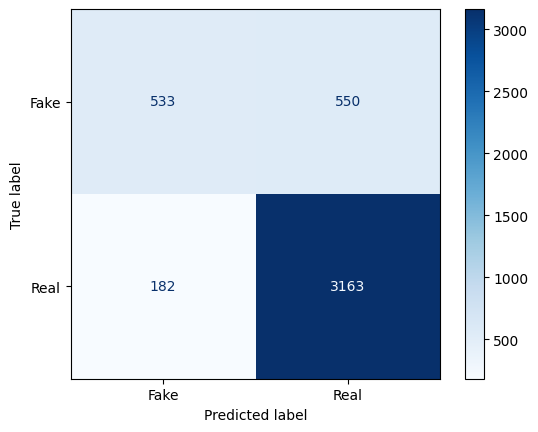

In [70]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
cm_display.plot(cmap='Blues')

In [71]:
from sklearn import metrics
print(metrics.classification_report(y_test ,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.49      0.59      1083
           1       0.85      0.95      0.90      3345

    accuracy                           0.83      4428
   macro avg       0.80      0.72      0.74      4428
weighted avg       0.83      0.83      0.82      4428



In [72]:
# confusion matrix
print(metrics.confusion_matrix(y_test ,y_pred))

[[ 533  550]
 [ 182 3163]]
